ConvNet classifier
=================

The second exercise is to build a Convolutional Neural Network to distuingish dogs from cats.

**Important: before you start, click "Runtime" in the top menu, then "Change runtime type", and ensure that Hardware accelerator "GPU" is selected. This should speed things up considerably.**

In [0]:
from pathlib import Path
import os
import zipfile

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

The following command will download the dataset:

In [0]:
TMP_DIR = Path("/tmp")
ZIPFILE = TMP_DIR / "cats_and_dogs_filtered.zip"
BASE_DIR = TMP_DIR / "cats_and_dogs_filtered"

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O $ZIPFILE

--2019-05-29 08:19:47--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   187MB/s    in 0.4s    

2019-05-29 08:19:47 (187 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
zipf = zipfile.ZipFile(ZIPFILE, "r")
zipf.extractall(TMP_DIR)
zipf.close()

Let's see what we just downloaded! We will use the linux command `ls`. The exclamation mark tells the notebook that we're executing a command-line instruction istead of a Python instruction:

In [5]:
!ls $BASE_DIR

train  validation  vectorize.py


In [6]:
!ls $BASE_DIR/train

cats  dogs


In [7]:
!ls $BASE_DIR/train/dogs|head -n 5

dog.0.jpg
dog.100.jpg
dog.101.jpg
dog.102.jpg
dog.103.jpg


In [8]:
!ls $BASE_DIR/train/cats|head -n 5

cat.0.jpg
cat.100.jpg
cat.101.jpg
cat.102.jpg
cat.103.jpg


Let's create some convenient variables to access these directories:

In [0]:
TRAIN_DIR = BASE_DIR / "train"
VAL_DIR = BASE_DIR / "validation"

TRAIN_DOG_DIR = TRAIN_DIR / "dogs"
TRAIN_CAT_DIR = TRAIN_DIR / "cats"

VAL_DOG_DIR = VAL_DIR / "dogs"
VAL_CAT_DIR = VAL_DIR / "cats"

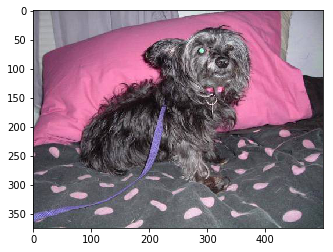

In [10]:
plt.imshow(plt.imread(TRAIN_DOG_DIR / "dog.0.jpg"))

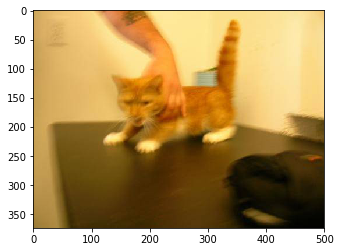

In [11]:
plt.imshow(plt.imread(TRAIN_CAT_DIR / "cat.0.jpg"))

Feel free to convince yourself that the other images are also dogs and cats.

**Question**: Is this dataset balanced or not?

In [12]:
len(list(TRAIN_DOG_DIR.glob("*.jpg")))

1000

In [13]:
len(list(TRAIN_CAT_DIR.glob("*.jpg")))

1000

What do you conclude on the use of the **accuracy** metric for this dataset?

**Answer: perfectly balanced. Let's use Accuracy for ease of representation. Randomly guessing is 50%, we should be able to beat that.**

# A simple ConvNet from scratch

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Exercise: check the dimensions of the images.**

Use `plt.imread()`, as above, to read on the cat or dog images. This function returns a numpy array. Check the shape of the numpy array.

For example, if `a` is a numpy array, you may call `a.shape` to get the shape.

The shape is in `(y, x, depth)`: the number of pixels in the y-direction (height), the number of pixels in the x-direction (width) and the number of channels (3 for each primary color). 

In [15]:
plt.imread(TRAIN_CAT_DIR / "cat.0.jpg").shape

(374, 500, 3)

Now assign **half** of these numbers to DIM_Y and DIM_X below.
That's right, we're resizing the image to be half of the original. This speeds things up and still allows us to reach reasonable performance.

**Tip: make sure DIM_Y and DIM_X are integers! Use type(var) to confirm**.

In [16]:
DIM_Y = 374 // 2
DIM_X = 500 // 2
print(DIM_Y, DIM_X, type(DIM_Y), type(DIM_X))

187 250 <class 'int'> <class 'int'>


We are now going to build the model.

We will build 3 groups of Convolution + MaxPooling. The first group has already been initialized below:

In [17]:
model = Sequential()
model.add(Conv2D(16, 3, input_shape=(DIM_Y, DIM_X, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

Instructions for updating:
Colocations handled automatically by placer.


For the second group, add a Conv2D with 32 filters, a ReLU activation, and a MaxPooling2D with pool size of 2.

In [0]:
model.add(Conv2D(32, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

The third group is the same, except increase the number of convolution filters to 64:

In [0]:
model.add(Conv2D(64, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))

Now, use `Flatten()` to go back to 1 dimension, and add a fully-connected layer with 512 nodes. Use `Dense(512)` to do that. Finally, use the ReLU activation function again:

In [0]:
model.add(Flatten()) 
model.add(Dense(512)) 
model.add(Activation('relu'))

We end with a Sigmoid node (`Dense(1)` with sigmoid activation function).

In [0]:
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [22]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
batch_size = 16  # Lower this to 8 if you get out of memory errors.

train_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(DIM_Y, DIM_X),
    batch_size=batch_size,
    class_mode="binary")

val_datagen = ImageDataGenerator(rescale=1/255)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(DIM_Y, DIM_X),
    batch_size=batch_size,
    class_mode="binary")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [23]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

In [24]:
model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=10,
        validation_data=val_generator,
        validation_steps=1000 // batch_size
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
125/125 [==============================] - 18s 145ms/step - loss: 0.7139 - acc: 0.5580 - val_loss: 0.6847 - val_acc: 0.5740
Epoch 2/10
125/125 [==============================] - 15s 119ms/step - loss: 0.6285 - acc: 0.6580 - val_loss: 0.6190 - val_acc: 0.6670
Epoch 3/10
125/125 [==============================] - 15s 116ms/step - loss: 0.5512 - acc: 0.7205 - val_loss: 0.6213 - val_acc: 0.6390
Epoch 4/10
125/125 [==============================] - 15s 118ms/step - loss: 0.4163 - acc: 0.8025 - val_loss: 0.6203 - val_acc: 0.6970
Epoch 5/10
125/125 [==============================] - 15s 116ms/step - loss: 0.2953 - acc: 0.8665 - val_loss: 0.7773 - val_acc: 0.6960
Epoch 6/10
125/125 [==============================] - 15s 118ms/step - loss: 0.1832 - acc: 0.9250 - val_loss: 0.9663 - val_acc: 0.7050
Epoch 7/10
125/125 [==============================] - 15s 117ms/step - loss: 0.0884 - acc: 0.9680 - val_loss: 1.1096 - val_acc: 0.6940
Epoch 8

How did this go? Did you manage to get reasonable accuracy?
You might notice that it's overfitting pretty heavily. Let's see what we can do.

## Data augmentations

Getting more training data usually helps with the overfitting problem. One cheap way to easily get more training data, is by "augmenting" the existing data. We can create new training images by applying random transformations on the existing images.

In the `ImageDataGenerator` above, that we assigned to `train_datagen`, we can add optional transformations.
For example:

    shear_range=0.1,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True 
    
Below, we'll define a new `ImageDataGenerator` with augmentations. Select a couple from above, or all, and feel free to change parameters to get more or less extreme augmentations.

In [27]:
train_datagen_aug = ImageDataGenerator(
    rescale=1/255,
    shear_range=0.1,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True 
)
train_generator_aug = train_datagen_aug.flow_from_directory(
    TRAIN_DIR,
    target_size=(DIM_Y, DIM_X),
    batch_size=batch_size,
    class_mode="binary")

Found 2000 images belonging to 2 classes.


Let's see some results:

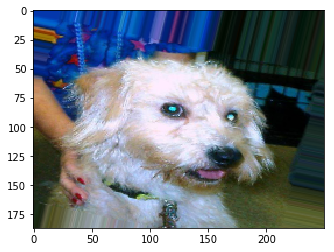

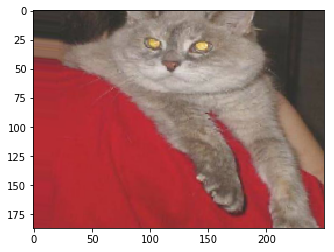

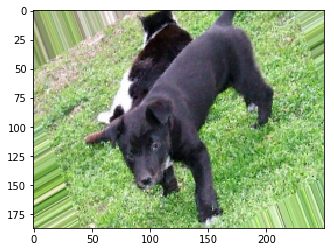

In [28]:
batch = next(train_generator_aug)[0]

for i in range(3):
    plt.imshow(batch[i, :])
    plt.show()

Don't go overboard: make sure it still looks realistic to the human eye. Tweak as necessary.

Let's see if this helps:

In [29]:
model_aug = Sequential()
model_aug.add(Conv2D(16, 3, input_shape=(DIM_Y, DIM_X, 3)))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=2))
model_aug.add(Conv2D(32, 3))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=2))
model_aug.add(Conv2D(64, 3))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=2))
model_aug.add(Flatten()) 
model_aug.add(Dense(512)) 
model_aug.add(Activation('relu'))
model_aug.add(Dense(1))
model_aug.add(Activation('sigmoid'))
model_aug.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_aug.fit_generator(
        train_generator_aug,
        steps_per_epoch=2000 // batch_size,
        epochs=10,
        validation_data=val_generator,
        validation_steps=1000 // batch_size
)

Epoch 1/10
125/125 [==============================] - 48s 381ms/step - loss: 0.7611 - acc: 0.5325 - val_loss: 0.6895 - val_acc: 0.5160
Epoch 2/10
125/125 [==============================] - 45s 363ms/step - loss: 0.6794 - acc: 0.5910 - val_loss: 0.6643 - val_acc: 0.6060
Epoch 3/10
125/125 [==============================] - 67s 538ms/step - loss: 0.6584 - acc: 0.6250 - val_loss: 0.6481 - val_acc: 0.6410
Epoch 4/10
125/125 [==============================] - 68s 543ms/step - loss: 0.6522 - acc: 0.6245 - val_loss: 0.6287 - val_acc: 0.6340
Epoch 5/10
125/125 [==============================] - 69s 549ms/step - loss: 0.6363 - acc: 0.6550 - val_loss: 0.6224 - val_acc: 0.6510
Epoch 6/10
125/125 [==============================] - 66s 530ms/step - loss: 0.6230 - acc: 0.6600 - val_loss: 0.5985 - val_acc: 0.6720
Epoch 7/10
125/125 [==============================] - 59s 473ms/step - loss: 0.5847 - acc: 0.7030 - val_loss: 0.6560 - val_acc: 0.6000
Epoch 8/10
125/125 [==============================] - 6

**Observation: Yes, it seems like it does! Training accuracy is down and validation accuracy is up. So there is less overfitting and it generalizes better to unseen data.**

Let's output some of the model's predictions:

In [0]:
def process_images(in_images):
    for img in in_images:
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0) / 255
        yield x
        
def show(model_):
    pred_class_label_map = {0: "cats", 1: "dogs"}
    actual_labels = 8 * ["cats"] + 8 * ["dogs"]
    random_img_paths = np.concatenate((np.random.choice(list(VAL_CAT_DIR.glob("*.jpg")), 8),
                                       np.random.choice(list(VAL_DOG_DIR.glob("*.jpg")), 8)))
    random_imgs = [image.load_img(file, target_size=(DIM_Y, DIM_X)) for file in random_img_paths]
    random_imgs_processed = list(process_images(random_imgs))

    # Predict:
    images = np.vstack(random_imgs_processed) 
    pred_classes = model_.predict_classes(images, batch_size=16).ravel()
    
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))

    for img, ax, actual_label, pred_class in zip(random_imgs_processed, axes.ravel(), actual_labels, pred_classes):
        pred_label = pred_class_label_map[pred_class]
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        result = "ok" if actual_label == pred_label else "NOK"
        ax.set_title("{}, y={}, {}={}".format(result, actual_label, '$\hat{y}$', pred_label))
        ax.imshow(img.squeeze())

    plt.tight_layout()
    plt.show()

In [31]:
show(model_aug)

Output hidden; open in https://colab.research.google.com to view.

# Open-ended bonus assignments
- Try increasing the representation size. Earlier, we only used half of the image. Does it help if we use 100% of the image?
- Overfitting can also be reduced by including a Dropout layer. Dropout randomly zeroes out neurons, which makes the model generalize better. Try putting a `Dropout(0.5)` between the Dense(512) and the Dense(1) layer, after the ReLU activation.
- Try increasing or decreasing the number of convolution filters, adding another block of Conv2D and MaxPooling, taking out a block or increasing or decreasing the number of nodes in the fully connected (Dense) layer. Sometimes it helps to add a second fully connected (Dense) layer. 
    - Note: It is definitely possible to improve on this simple Convolutional Neural Network, but you'll probably find that iterating towards the optimal architecture is quite difficult and time consuming. Welcome to the everyday challenges of a data scientist :-)